In [7]:
import pandas as pd

df = pd.read_csv("../ML-Exam/data/cleaned_airbnb_data.csv")
df.info()
df.describe()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50677 entries, 0 to 50676
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          50677 non-null  int64  
 1   realSum                     50677 non-null  float64
 2   room_type                   50677 non-null  object 
 3   room_shared_bool            50677 non-null  int64  
 4   room_private_bool           50677 non-null  int64  
 5   person_capacity             50677 non-null  int64  
 6   host_is_superhost_bool      50677 non-null  int64  
 7   multi_bool                  50677 non-null  int64  
 8   biz_bool                    50677 non-null  int64  
 9   cleanliness_rating          50677 non-null  int64  
 10  guest_satisfaction_overall  50677 non-null  int64  
 11  bedrooms                    50677 non-null  int64  
 12  dist                        50677 non-null  float64
 13  metro_dist                  506

,ID,realSum,room_type,room_shared_bool,room_private_bool,person_capacity,host_is_superhost_bool,multi_bool,biz_bool,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,City,Is_weekend_bool
0,0,194.03,Private room,0,1,2,0,1,0,10,93,1,5.0,2.5,Amsterdam,0
1,1,344.25,Private room,0,1,4,0,0,0,8,85,1,0.5,0.2,Amsterdam,0
2,2,264.10,Private room,0,1,2,0,0,1,9,87,1,5.7,3.7,Amsterdam,0
3,3,433.53,Private room,0,1,4,0,0,1,9,90,2,0.4,0.4,Amsterdam,0
4,4,485.55,Private room,0,1,2,1,0,0,10,98,1,0.5,0.3,Amsterdam,0


In [39]:
from sklearn.preprocessing import StandardScaler

# Select relevant features
features = [
    'realSum',
    'person_capacity',
    'host_is_superhost_bool',
    'cleanliness_rating',
    'guest_satisfaction_overall',
    'bedrooms',
    'dist',
    'metro_dist',
    'Is_weekend_bool',
    'room_private_bool'
]

# Extract feature dataframe and scale
df_cluster = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Display scaled data sample
pd.DataFrame(X_scaled, columns=features).head()


,realSum,person_capacity,host_is_superhost_bool,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,Is_weekend_bool,room_private_bool
0,-0.389260,-0.883520,-0.587977,0.639849,0.044653,-0.230737,0.748128,2.098499,-1.01277,1.313285
1,0.591416,0.671678,-0.587977,-1.456387,-0.851441,-0.230737,-1.124921,-0.561917,-1.01277,1.313285
2,0.068176,-0.883520,-0.587977,-0.408269,-0.627418,-0.230737,1.039491,3.486543,-1.01277,1.313285
3,1.174259,0.671678,-0.587977,-0.408269,-0.291383,1.407405,-1.166544,-0.330577,-1.01277,1.313285
4,1.513859,-0.883520,1.700747,0.639849,0.604711,-0.230737,-1.124921,-0.446247,-1.01277,1.313285


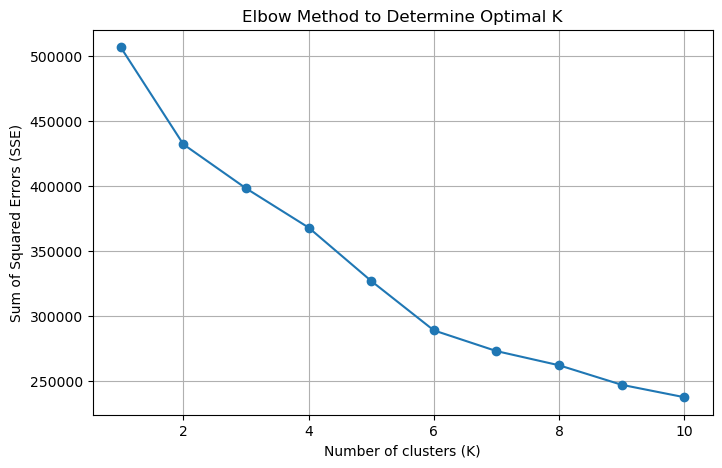

In [41]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, sse, marker='o')
plt.title('Elbow Method to Determine Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()


In [65]:
optimal_k = 4  # Update this based on your elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

In [67]:
cluster_summary = df.groupby('cluster')[features].mean()
cluster_summary


,realSum,person_capacity,host_is_superhost_bool,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,Is_weekend_bool,room_private_bool
cluster,,,,,,,,,,
0,188.401008,2.270727,0.228423,9.335140,92.088967,1.000425,4.002360,0.870504,0.000000,0.969600
1,366.391789,4.887036,0.268302,9.416465,92.837196,2.063415,2.924726,0.679967,0.493843,0.029865
2,194.233469,2.268154,0.221953,9.343191,92.188592,1.001789,4.102410,0.898937,1.000000,0.964429
3,254.399477,3.058590,0.279388,9.420947,92.895497,0.820546,2.586991,0.513191,0.515755,0.000233


In [69]:
df['cluster'].value_counts().sort_index()


cluster
0     9408
1    10313
2     9502
3    21454
Name: count, dtype: int64

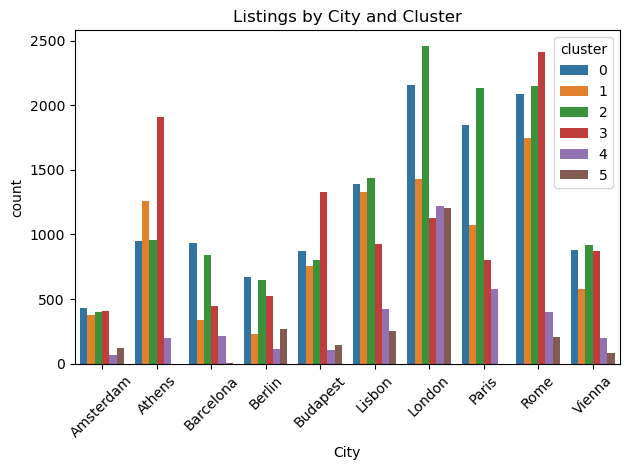

In [59]:
import seaborn as sns

sns.countplot(data=df, x='City', hue='cluster')
plt.title("Listings by City and Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


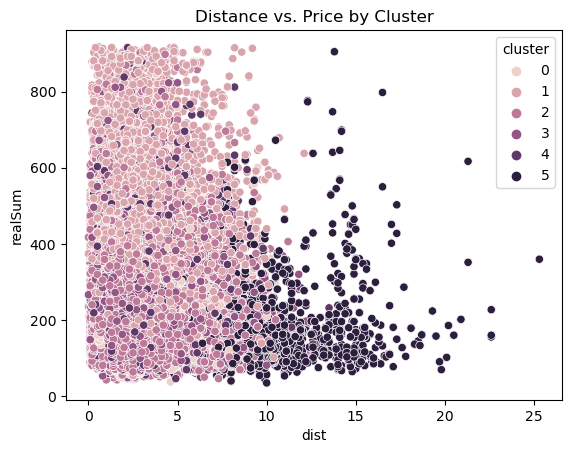

In [61]:
sns.scatterplot(data=df, x='dist', y='realSum', hue='cluster')
plt.title("Distance vs. Price by Cluster")
plt.show()
